<a href="https://colab.research.google.com/github/FeedingDejaj/MAT421/blob/main/FinalPaper_Liverpool_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Liverpool FC’s Points Curve with Euler & RK4


# **Introduction**

In any competitive sport, momentum can feel like an almost mystical force: one week a team looks invincible, and the next they can't string together 5 passes. Football, known as Soccer in the US, is no exception. Over a long 8 week season, each matchday adds a progresses a team forward or keeps them still. Three points for a win, one for a draw, nothing for a loss. What if we could take that week-to-week accumulation of points and use it as the solution to a simple differential equation?


That is the purpose of this project. By regarding cumulative points $P(n)$ as a function of matchday $n$ and defining the “instantaneous rate” of point gain $α(n)$ as the difference $P(n+1)−P(n)$, we turn Liverpool’s 2022–23 Premier League season into an initial-value problem:

$\frac{dP}{dn} = \alpha(n),\quad P(0) = 0$


From there, two classical numerical solvers, the first-order Euler method and the fourth-order Runge–Kutta (RK4), offer ways to reconstruct and explore the points curve at noninteger matchdays (between each matchday).
<br>
<br>
Why do we use these two methods? Euler’s method is pretty straightforward: it advances the solution by stepping forward in proportion to the current slope. RK4 samples the slope at four points within each step and takes a weighted average. Together, they show how higher-order techniques can improve accuracy without a proportional increase in coding complexity.
<br>
<br>
This project goes through each step of our process. First, raw match-by-match data are imported from a public CSV and transformed into a cumulative points array. Then, both solvers are implemented and their outputs are plotted against Liverpool’s actual season results. Error analysis on a log–log scale then counts how step size influences overall accuracy. This shows the familiar linear convergence of Euler and the fourth-order decay of RK4 when the underlying slope function varies smoothly even though the RK4 slope is much steeper. Finally, we compare with SciPy’s adaptive RK45 solver to confirm that our simple process 'match' against standard tools. Pun intended.
<br>
<br>
This project demonstrates a broader lesson: numerical methods are not confined to textbooks and boring applications. Even in the context of Football, they can show us performance trends, forecast changes in form, and change how we think about speed, simplicity, and precision. I have included detailed derivations and clear implementation steps. This was done mostly as an exercise for myself but it provides insight on how this process works.

# **Math Method**

We develop the numerical framework for remaking and interpolating Liverpool’s cumulative points curve by treating it as an initial‐value problem. First, we cast the discrete point tally into a simple ODE. Then we derive two solutions: Euler’s method and the classic fourth‐order Runge–Kutta (RK4) method. Then we show some of their error behavior.
<br>
<br>
## **ODE Formulation**

Let $n$ denote the matchday (an integer from 0 to 38) and $P(n)$ be Liverpool’s total points after $n$ games. Define the point‐gain function
<br>
<br>
$α(n)=P(n+1)−P(n)$,
<br>
<br>
so that each match contributes $0$, $1$, or $3$ points. We then view $P(n)$ as the solution to the initial‐value problem
<br>
<br>
$\frac{dP}{dn} = \alpha(n),\quad P(0) = 0$
<br>
<br>
Although $n$ is naturally integer‐valued, framing it this way allows us to approximate $P(t)$ at noninteger $t$, revealing the “in‐between” behavior of the points curve.
<br>
<br>
## **Euler's Method**
Euler’s method is the simplest fixed step solver for an ODE of the form
<br>
<br>
$\frac{dy}{dt} = f(t,y) , \quad y(t_0)=y_0$.
<br>
<br>
Over a step of size $h$, it steps by
<br>
<br>
$y_{n+1} = y_n + h\,f(t_n, y_n)$
<br>
<br>

In our football points setting, $f$ depends only on $t$ (not on $P$), so
<br>
<br>
$P_{n+1} ​= P_n ​+ hα(n)$
<br>
<br>

We take $P_0=0$, choose various $h≤1$, and step from $n=0$ to $n=38$.
<br>
<br>

## **Local and Global Error**

Local truncation error measures the error incurred over a single step. For Euler’s method it scales like $O(h^2)$.

Global error accumulates over $∼1/h$ steps, giving an overall $O(h)$ convergence rate.

On a log–log plot of max error versus $h$, we expect a slope of approximately 1 for Euler’s method.



## **Runge–Kutta 4 (RK4)**

RK4 achieves much higher accuracy by sampling the slope four times within each step.
<br>
<br>
$k_1 =f(t_n​,P_n​),$ <br> <br>
$k_2 =f(t_n​+\frac{2}{h}​,P_n + ​\frac{2}{h}​k_1​),$ <br><br>
$k_3 =f(t_n​+\frac{2}{h}​,P_n + ​\frac{2}{h}​k_2​),$ <br><br>
$k_4 =f(t_n​+h​,P_n + ​h​k_3),$ <br><br>

The update is <br><br>

$P_{n+1​}=P_n​+ \frac6h​(k_1​+2k_2​+2k_3​+k_4​)$
<br><br>

Since our right‐hand side is $f(t,P)=α(⌊t⌋)$ <br><br>
$k_1=α(n),$ <br><br>
$k_2=α ⁣(n+\frac h2),$ <br><br>
$k_3=α ⁣(n+\frac h2),$ <br><br>
$k_4=α(n+h).$ <br><br>

Error Characteristics

- Local truncation error for RK4 scales like $O(h^5)$.

- Global error therefore behaves like $O(h^4)$, yielding a slope of approximately $4$ on the same log–log plot.




---



# **Implementation**



**Imports**

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

**Load & Prepare Data**

In [41]:
url = "https://www.football-data.co.uk/mmz4281/2223/E0.csv"
all_matches = pd.read_csv(url)

is_liverpool = (
    (all_matches["HomeTeam"] == "Liverpool") |
    (all_matches["AwayTeam"] == "Liverpool")
)
lp = all_matches[is_liverpool].sort_values("Date").reset_index(drop=True)

def match_points(row):
    if row["HomeTeam"] == "Liverpool":
        return 3 if row["FTR"] == "H" else (1 if row["FTR"] == "D" else 0)
    else:
        return 3 if row["FTR"] == "A" else (1 if row["FTR"] == "D" else 0)

lp["Pts"] = lp.apply(match_points, axis=1)

P_data = np.concatenate(([0], lp["Pts"].cumsum()))
alpha  = np.diff(P_data)


**Define the ODE right-hand side**

In [42]:
def f_piecewise(t):
    day = int(np.floor(t))
    day = min(day, len(alpha)-1)
    return alpha[day]

interp = interp1d(
    np.arange(len(alpha)), alpha,
    kind="linear", fill_value="extrapolate"
)
def f_continuous(t):
    return float(interp(t))


**Implement Euler & RK4**

In [43]:
def euler(f, P0, t0, t_final, h):
    ts = np.linspace(t0, t_final, int((t_final-t0)/h)+1)
    Ps = np.zeros_like(ts)
    Ps[0] = P0
    for i in range(len(ts)-1):
        Ps[i+1] = Ps[i] + h * f(ts[i])
    return ts, Ps

def rk4(f, P0, t0, t_final, h):
    ts = np.linspace(t0, t_final, int((t_final-t0)/h)+1)
    Ps = np.zeros_like(ts)
    Ps[0] = P0
    for i in range(len(ts)-1):
        t, P = ts[i], Ps[i]
        k1 = f(t)
        k2 = f(t + h/2)
        k3 = f(t + h/2)
        k4 = f(t + h)
        Ps[i+1] = P + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return ts, Ps


**Compare Solvers on P_data**

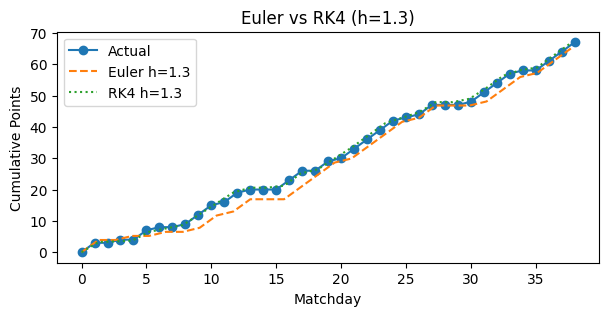

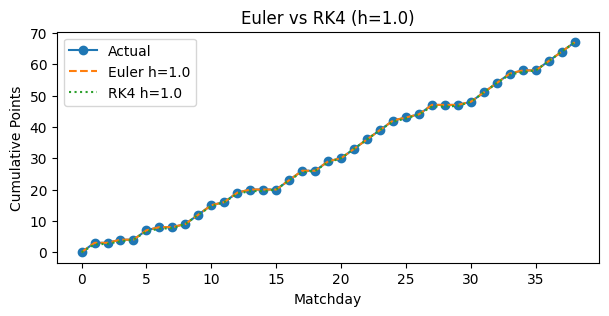

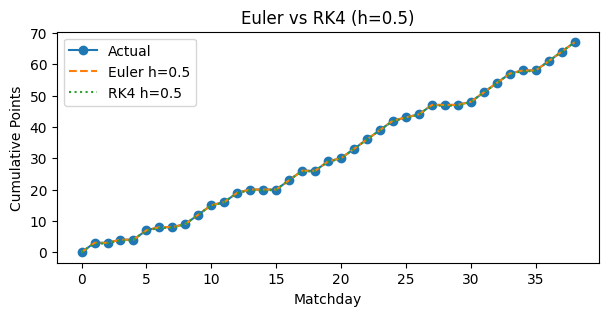

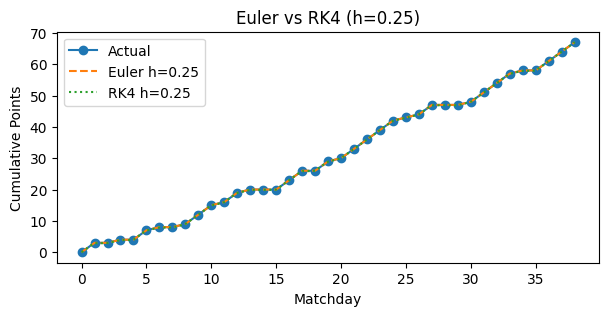

In [44]:
for h in [1.3, 1.0, 0.5, 0.25]:
    te, Pe = euler_solve(f_piecewise, 0, 0, 38, h)
    tr, Pr = rk4_solve(  f_piecewise, 0, 0, 38, h)

    plt.figure(figsize=(7,3))
    plt.plot(np.arange(39), P_data, "o-", label="Actual")
    plt.plot(te, Pe, "--", label=f"Euler h={h}")
    plt.plot(tr, Pr, ":",  label=f"RK4 h={h}")
    plt.xlabel("Matchday")
    plt.ylabel("Cumulative Points")
    plt.title(f"Euler vs RK4 (h={h})")
    plt.legend()
    plt.show()

**Error vs Step-Size (Piecewise f)**

      h   Euler error  RK4 error
0  2.00  1.000000e+01   4.500000
1  1.30  5.100000e+00   1.233333
2  1.00  0.000000e+00   0.500000
3  0.50  0.000000e+00   0.250000
4  0.25  0.000000e+00   0.125000
5  0.10  1.705303e-13   0.050000


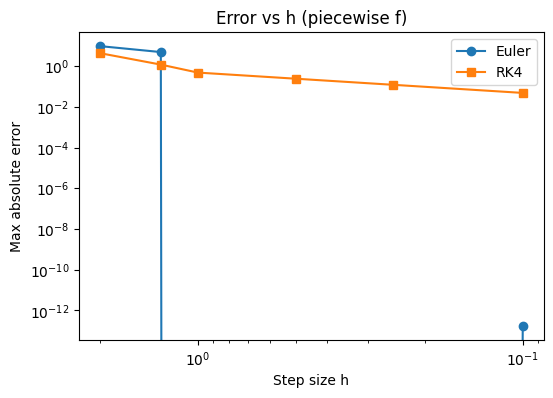

In [45]:
hs = [2.0, 1.3, 1.0, 0.5, 0.25, 0.1]
err_e = []; err_r = []

for h in hs:
    te, Pe = euler_solve(f_piecewise,   0, 0, 38, h)
    tr, Pr = rk4_solve(f_piecewise,     0, 0, 38, h)
    Pe_i = np.interp(np.arange(39), te, Pe)
    Pr_i = np.interp(np.arange(39), tr, Pr)
    err_e.append(np.max(np.abs(Pe_i - P_data)))
    err_r.append(np.max(np.abs(Pr_i - P_data)))

df_err = pd.DataFrame({
    "h": hs,
    "Euler error": err_e,
    "RK4 error":   err_r
})
print(df_err)

plt.figure(figsize=(6,4))
plt.loglog(df_err["h"], df_err["Euler error"], 'o-', label="Euler")
plt.loglog(df_err["h"], df_err["RK4 error"],   's-', label="RK4")
plt.gca().invert_xaxis()
plt.xlabel("Step size h")
plt.ylabel("Max absolute error")
plt.title("Error vs h (piecewise f)")
plt.legend()
plt.show()

**Error vs Step-Size (Continuous f)**

      h  Euler error  RK4 error
0  2.00       10.000       4.50
1  1.30        2.110       1.75
2  1.00        0.000       1.50
3  0.50        0.750       1.50
4  0.25        1.125       1.50
5  0.10        1.350       1.50


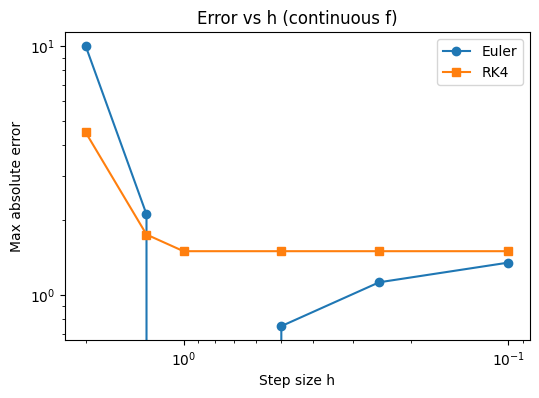

In [46]:
err_ec = []; err_rc = []

for h in hs:
    te, Pe = euler_solve(f_continuous,   0, 0, 38, h)
    tr, Pr = rk4_solve(f_continuous,     0, 0, 38, h)
    Pe_i = np.interp(np.arange(39), te, Pe)
    Pr_i = np.interp(np.arange(39), tr, Pr)
    err_ec.append(np.max(np.abs(Pe_i - P_data)))
    err_rc.append(np.max(np.abs(Pr_i - P_data)))

df_errc = pd.DataFrame({
    "h": hs,
    "Euler error": err_ec,
    "RK4 error":   err_rc
})
print(df_errc)

plt.figure(figsize=(6,4))
plt.loglog(df_errc["h"], df_errc["Euler error"], 'o-', label="Euler")
plt.loglog(df_errc["h"], df_errc["RK4 error"],   's-', label="RK4")
plt.gca().invert_xaxis()
plt.xlabel("Step size h")
plt.ylabel("Max absolute error")
plt.title("Error vs h (continuous f)")
plt.legend()
plt.show()


**Compare to SciPy’s RK45**


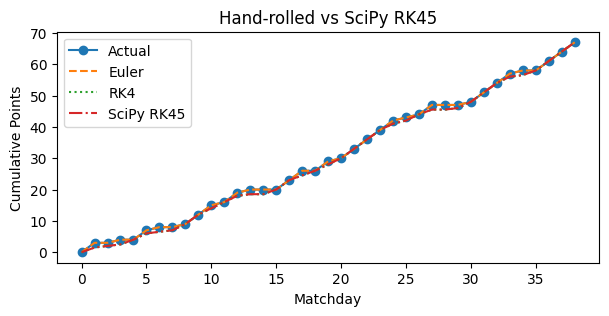

In [47]:
def f_ivp(t, y):
    return f_continuous(t)

t_eval = np.arange(0, 39)
sol = solve_ivp(f_ivp, (0,38), [0], max_step=1.0, t_eval=t_eval)

plt.figure(figsize=(7,3))
plt.plot(np.arange(39), P_data,      "o-", label="Actual")
te, Pe = euler_solve(f_continuous, 0,  0, 38, 1.0)
tr, Pr = rk4_solve(f_continuous,   0,  0, 38, 1.0)
plt.plot(te, Pe, "--",  label="Euler")
plt.plot(tr, Pr, ":",   label="RK4")
plt.plot(sol.t, sol.y[0], "-.", label="SciPy RK45")
plt.xlabel("Matchday"); plt.ylabel("Cumulative Points")
plt.title("Hand-rolled vs SciPy RK45")
plt.legend()
plt.show()

# **Data**

In this study, we use match-by-match results for Liverpool’s 2022–23 Premier League season downloaded from Football-Data.co.uk (the “E0” CSV file for 2022–23). The raw file contains one row per fixture with columns like Date, HomeTeam, AwayTeam, FTHG (full-time home goals), FTAG, and FTR (full-time result: H/D/A).

# **References**

Kong, Q., & Siauw, T. (2015). Python Programming and Numerical Methods: A Guide for Engineers and Scientists. Retrieved May 1, 2025, from https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/Index.html

Football-Data.co.uk. (2023). England Premier League 2022/23 (E0) match results [CSV]. Retrieved May 1, 2025, from https://www.football-data.co.uk/mmz4281/2223/E0.csv

OpenAI. (2025). ChatGPT (April 26 version) [Large language model]. https://chat.openai.com/chat